## Degrees and HMS Conversion

In [45]:
from astropy.coordinates import SkyCoord
import astropy.units as u

ra_deg = 175.873995
dec_deg = -16.798

coord = SkyCoord(ra=ra_deg*u.degree, dec=dec_deg*u.degree, frame='icrs')
#print(f"RA (H:M:S): {coord.ra.to_string(unit=u.hour, sep=':')}")
#print(f"Dec (D:M:S): {coord.dec.to_string(unit=u.degree, sep=':', alwayssign=True)}")

c = SkyCoord('02h11m34.00s', '43d58m47.1s', frame='icrs')
ra_deg_c = c.ra.deg
dec_deg_c = c.dec.deg
print(f"RA in degrees: {ra_deg_c:.6f}")
print(f"Dec in degrees: {dec_deg_c:.6f}")

RA in degrees: 32.891667
Dec in degrees: 43.979750


## UTC to MJD

In [15]:
from astropy.time import Time
import pandas as pd

utc_dates = [
    '2019-12-11 10:17:11.000'
    ]

for date in utc_dates:
    t = Time(date, format='iso', scale='utc')
    print(f"{t.mjd:.5f}")

58828.42860


## TigerVNC Output Viewer

In [ ]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import time

file_path = "/Users/Djslime07/Downloads/SN2019pqo_Cband_regcal.fits"
name = 'SN2019pqo'
band = 'C Band'
calib_type = 'RegCal'

with fits.open(file_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    im = data[0, 0]
    print(header)

    date = header['DATE-OBS']
    mjd = astropy.time.Time(date).mjd
    print(f"Observation date: {date}")
    print(f"MJD: {mjd}")
    print(f"Days since explosion: {mjd - 58733.212419}")

    zoom_arcsec = 12
    pixscale = np.abs(header['CDELT2'] * 3600) 
    half_pix = int((zoom_arcsec / pixscale) / 2)
    y_center, x_center = np.array(im.shape) // 2
    zoom_im = im[y_center-half_pix:y_center+half_pix, x_center-half_pix:x_center+half_pix]

    zoom_masked = np.ma.masked_invalid(zoom_im)
    std_temp = np.ma.std(zoom_masked)
    keep = np.ma.abs(zoom_masked) <= 3 * std_temp
    rms = np.ma.std(zoom_masked[keep])
    peak_flux = np.ma.max(zoom_masked)

    print(f"RMS: {rms:.5e} Jy")
    print(f"Peak Flux: {peak_flux:.5e} Jy")

    fig, ax = plt.subplots()
    extent = [-zoom_arcsec/2, zoom_arcsec/2, -zoom_arcsec/2, zoom_arcsec/2]
    imshow = ax.imshow(zoom_masked, cmap='YlOrRd', origin='lower', extent=extent)

    peak_str = f"Peak Flux: {peak_flux*1e3:.3f} mJy"
    rms_str = f"RMS Flux: {rms*1e3:.3f} mJy"
    ax.set_title(f"{name} {band} {calib_type} | MJD: {mjd:.5f} \n {peak_str} | {rms_str}")
    ax.set_xlabel("RA Offset (arcsec)")
    ax.set_ylabel("Dec Offset (arcsec)")
    plt.colorbar(imshow)
    plt.show()

## FITS to PNG - Optimized

In [ ]:
import numpy as np
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.time import Time
import numpy.ma as ma

def determine_band(freq_ghz):
    if 2.5 <= freq_ghz <= 3.5:
        return 'S'
    elif 5.5 <= freq_ghz <= 7.5:
        return 'C'
    elif 8.5 <= freq_ghz <= 10.5:
        return 'X'
    else:
        return 'Unknown'

def generate_cutout(imname, optical_date):
    try:
        with pyfits.open(imname, ignore_missing_simple=True) as hdulist:
            im = hdulist[0].data[0, 0]
            if im.size == 0:
                print("Error: Image data is empty.")
                return

            hdr = hdulist[0].header
            w = WCS(hdr)

            ra_deg = hdr['CRVAL1']
            dec_deg = hdr['CRVAL2']
            print(f"Cutout centered at position {ra_deg:.6f}, {dec_deg:.6f}")

            src_pix = w.wcs_world2pix([[ra_deg, dec_deg, 0, 0]], 0)
            x, y = src_pix[0, 0], src_pix[0, 1]

            pix1 = hdr['CRPIX1']
            pix2 = hdr['CRPIX2']
            badx = x < 0 or x > 2 * pix1
            bady = y < 0 or y > 2 * pix2
            if badx and bady:
                print("Tile has not been imaged at the source position.")
                return

            freqs = hdr['CRVAL3'] / 1e9  
            band = determine_band(freqs)

            if band == 'S':
                image_dim_arcsec = 24
            elif band == 'C':
                image_dim_arcsec = 12
            elif band == 'X':
                image_dim_arcsec = 6
            else:
                image_dim_arcsec = 12  

            delt1 = hdr['CDELT1']
            delt2 = hdr['CDELT2']
            cutout_size = image_dim_arcsec / 3600
            dside1 = -cutout_size / 2. / delt1
            dside2 = cutout_size / 2. / delt2

            im_plot_raw = im[int(y - dside1):int(y + dside1), int(x - dside2):int(x + dside2)]
            im_plot = ma.masked_invalid(im_plot_raw)

            rms_temp = ma.std(im_plot)
            keep = ma.abs(im_plot) <= 3 * rms_temp
            rms = ma.std(im_plot[keep])

            if im_plot.flatten().size == 0:
                print("No valid data in cutout.")
                return

            peak_flux = ma.max(im_plot.flatten())

            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(np.flipud(im_plot),
                      extent=[-0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600.,
                              -0.5 * cutout_size * 3600., 0.5 * cutout_size * 3600.],
                      vmin=-1e-4, vmax=1e-3, cmap='YlOrRd')

            peakstr = f"Peak Flux {np.round(peak_flux * 1e3, 3)} mJy"
            rmsstr = f"RMS Flux {np.round(rms * 1e3, 3)} mJy"
            obs_date = hdr['DATE-OBS']
            mjd = Time(obs_date).mjd
            name = hdr.get('OBJECT', 'Unknown')
            diff_days = mjd - optical_date

            with open(output_file, 'a') as f:
                print(f"{name}_{band} Band,{diff_days}", file=f)

            ax.set_title(f"{name} {band} Band | MJD: {mjd:.5f}\n{peakstr} | {rmsstr}\nCutout Size: {image_dim_arcsec} x {image_dim_arcsec} arcsec")
            plt.xlabel("Offset in RA (arcsec)")
            plt.ylabel("Offset in Dec (arcsec)")
            plt.show()

            return peak_flux, rms, mjd

    except Exception as e:
        print(f"Error processing FITS file: {e}")
        return

output_file = "/Users/Djslime07/VLA_Summer25/HTML Supplies/cutout_outputs.csv"

generate_cutout(
    imname = "/Users/Djslime07/Downloads/25A-386_Cutouts/oussid.SN2023axu_sci.X_band.cont.regcal.I.tt0.fits",
    optical_date = 59972.11622
)

## mJy to Erg/S 

In [ ]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18
import astropy.units as u

df = pd.read_csv("/Users/Djslime07/VLA_Summer25/temp.csv")

flux_cgs = df['Flux'] * 1e-26 

d_L = Planck18.luminosity_distance(df['Redshift']).cgs.value 

L_nu = 4 * np.pi * d_L**2 * flux_cgs * (1 + df['Redshift'])

df['luminosity (erg/s/Hz)'] = L_nu
print(L_nu)
df.to_csv('temp.csv', index=False)

## Light Curve Plotting

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

df = pd.read_csv("light_curve_data.csv")
df.columns = df.columns.str.strip()
df['Status'] = df['Status'].str.strip()

if 'PredictedFlux' not in df.columns:
    df['PredictedFlux'] = np.nan

supernovae = df['Name'].unique()
colormap = cm.get_cmap('cool', len(supernovae))

for i, name in enumerate(supernovae):
    subdf = df[df['Name'] == name]
    explosion_dates = subdf['ExplosionDate'].dropna().values
    explosion_date = explosion_dates[0] if len(explosion_dates) > 0 else None
    color = colormap(i)

    real_df = subdf[subdf['Status'] == 'real']
    upper_df = subdf[subdf['Status'] == 'upper']
    pred_df = subdf[subdf['PredictedFlux'].notna()]

    calcflux_df = subdf[subdf['CalculatedFlux'].notna()]
    if not calcflux_df.empty:
        for _, row in calcflux_df.iterrows():
            ax1.scatter(row['MJD'], row['CalculatedFlux'], marker='*', color='gold', s=100, label='Calculated Flux')


    fig, ax1 = plt.subplots()

    subdf_sorted = subdf.sort_values(by='MJD')
    ax1.plot(subdf_sorted['MJD'], subdf_sorted['Flux'], linestyle='--', color=color, alpha=0.6)

    if not real_df.empty:
        ax1.errorbar(real_df['MJD'], real_df['Flux'], yerr=real_df['RMS'],
                     fmt='o', color=color, ecolor=color, capsize=10, label='Flux Detection')

    if not upper_df.empty:
        ax1.errorbar(upper_df['MJD'], upper_df['Flux'],
                     fmt='v', color=color, ecolor=color, capsize=10, label='Upper Limit')

    if explosion_date is not None:
        ax1.axvline(x=explosion_date, color='red', linestyle=':', label='Explosion Date')

    plotted_pred_label = False
    for _, row in pred_df.iterrows():
        ax1.scatter(row['MJD'], row['PredictedFlux'], marker='x', color='black',
                    s=50, label='Predicted Flux' if not plotted_pred_label else "")
        plotted_pred_label = True

    calcflux_df = subdf[subdf['CalculatedFlux'].notna()]
    if not calcflux_df.empty:
        for _, row in calcflux_df.iterrows():
            ax1.scatter(row['MJD'], row['CalculatedFlux'], marker='*', color='gold', s=100, label='Estimated Flux')
    
    ax1.set_xlabel("MJD")
    ax1.set_ylabel("Flux Density (mJy)")
    ax1.set_title(f"{name} S Band Radio Luminosity Versus Time")
    ax1.grid(True, which="both", ls="--")
    ax1.legend(loc='upper left')

    def mjd_to_tse(x):
        return x - explosion_date if explosion_date is not None else x

    def tse_to_mjd(x):
        return x + explosion_date if explosion_date is not None else x

    ax2 = ax1.secondary_xaxis('top', functions=(mjd_to_tse, tse_to_mjd))
    ax2.set_xlabel("Time Since Explosion (days)")

    ax3 = ax1.twinx()
    ax3.set_ylabel("Luminosity $L_\\nu$ (erg/s/Hz)")
    ax3.set_yscale("log")

    ax3.plot(subdf_sorted['MJD'], subdf_sorted['luminosity (erg/s/Hz)'],
             linestyle=':', color='white', alpha=0.7, label='Luminosity')

    plt.tight_layout()
    plt.savefig(f'/Users/Djslime07/VLA_Summer25/light_curves/{name}_Sband_lightcurve.pdf', format='pdf', bbox_inches='tight')
    

## Frequencies and Fluxes Outputs

In [ ]:
import numpy as np
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.time import Time
import numpy.ma as ma
import os
from collections import defaultdict

def determine_band(freq_ghz):
    if 2.5 <= freq_ghz <= 3.5:
        return 'S'
    elif 5.5 <= freq_ghz <= 7.5:
        return 'C'
    elif 8.5 <= freq_ghz <= 10.5:
        return 'X'
    else:
        return 'Unknown'

def generate_cutout(imname, image_dim_arcsec=6):
    try:
        with pyfits.open(imname, ignore_missing_simple=True) as hdulist:
            im = hdulist[0].data[0, 0]
            if im.size == 0:
                print("Error: Image data is empty.")
                return None

            hdr = hdulist[0].header
            w = WCS(hdr)

            ra_deg = hdr['CRVAL1']
            dec_deg = hdr['CRVAL2']

            src_pix = w.wcs_world2pix([[ra_deg, dec_deg, 0, 0]], 0)
            x, y = src_pix[0, 0], src_pix[0, 1]

            pix1 = hdr['CRPIX1']
            pix2 = hdr['CRPIX2']
            badx = x < 0 or x > 2 * pix1
            bady = y < 0 or y > 2 * pix2
            if badx and bady:
                print("Tile has not been imaged at the source position.")
                return None

            delt1 = hdr['CDELT1']
            delt2 = hdr['CDELT2']
            cutout_size = image_dim_arcsec / 3600
            dside1 = -cutout_size / 2. / delt1
            dside2 = cutout_size / 2. / delt2

            im_plot_raw = im[int(y - dside1):int(y + dside1), int(x - dside2):int(x + dside2)]
            im_plot = ma.masked_invalid(im_plot_raw)

            rms_temp = ma.std(im_plot)
            keep = ma.abs(im_plot) <= 3 * rms_temp
            rms = ma.std(im_plot[keep])

            if im_plot.flatten().size == 0:
                print("No valid data in cutout.")
                return None

            peak_flux = ma.max(im_plot.flatten())
            obs_date = hdr['DATE-OBS']
            mjd = Time(obs_date).mjd
            name = hdr.get('OBJECT', 'Unknown')
            freqs = hdr['CRVAL3'] / 1e9
            band = determine_band(freqs)

            return {
                "name": name,
                "band": band,
                "freq_ghz": freqs,
                "peak_flux_mjy": np.round(peak_flux * 1e3, 3),
                "rms_mjy": np.round(rms * 1e3, 3),
                "mjd": mjd
            }

    except Exception as e:
        print(f"Error processing FITS file: {e}")
        return None

input_folder = "/Users/Djslime07/Downloads/25A-386_Cutouts"
results_by_name = defaultdict(list)

for fits_file in sorted(os.listdir(input_folder)):
    if fits_file.endswith(".fits") and not fits_file.startswith("._"):
        fits_path = os.path.join(input_folder, fits_file)
        print(f"Processing: {fits_path}")
        result = generate_cutout(imname=fits_path, image_dim_arcsec=6)
        if result:
            results_by_name[result['name']].append(result)

output_file = '/Users/Djslime07/VLA_Summer25/freq_and_fluxes.csv'
band_order = {'S': 0, 'C': 1, 'X': 2}

with open(output_file, 'w') as f:
    f.write("Name,Band,Freq_GHz,PeakFlux_mJy,RMS_mJy,MJD\n")
    for name in sorted(results_by_name):
        entries = results_by_name[name]
        entries.sort(key=lambda x: band_order.get(x['band'], 99))
        for entry in entries:
            f.write(f"{entry['name']},{entry['band']},{entry['freq_ghz']},"
                    f"{entry['peak_flux_mjy']},{entry['rms_mjy']},{entry['mjd']:.5f}\n")

## Frequency versus Fluxes Plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

csv_path = '/Users/Djslime07/VLA_Summer25/freq_and_fluxes.csv'
df = pd.read_csv(csv_path)

df.columns = ['Name', 'Band', 'Freq_GHz', 'PeakFlux_mJy', 'RMS_mJy', 'MJD']

df['Freq'] = pd.to_numeric(df['Freq_GHz'], errors='coerce')
df['Flux'] = pd.to_numeric(df['PeakFlux_mJy'], errors='coerce')
df['RMS'] = pd.to_numeric(df['RMS_mJy'], errors='coerce')
df.dropna(subset=['Freq', 'Flux', 'RMS'], inplace=True)

supernovae = df['Name'].unique()
colormap = cm.get_cmap('cool', len(supernovae)) 

plot_dir = "/Users/Djslime07/VLA_Summer25/freqflux_plots"
os.makedirs(plot_dir, exist_ok=True)

for idx, (name, group) in enumerate(df.groupby('Name')):
    group = group.sort_values('Freq')  

    plt.figure(figsize=(6, 4))
    plt.errorbar(
        group['Freq'],
        group['Flux'],         
        yerr=group['RMS'],
        fmt='o--', capsize=4,
        color=colormap(idx),
        label=name
    )

    plt.title(f"{name} — Flux vs Frequency")
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Peak Flux Density (mJy)")
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(plot_dir, f"{name}_freq_vs_flux.png")
    plt.savefig(plot_path, dpi=150)

## Power Law Fits and Plots

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os

def power_law(nu, A, beta):
    return A * nu ** beta

input_csv = "/Users/Djslime07/VLA_Summer25/freq_and_fluxes.csv"
data = pd.read_csv(input_csv)

for col in ["Freq_GHz", "PeakFlux_mJy", "RMS_mJy"]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna(subset=["Freq_GHz", "PeakFlux_mJy", "RMS_mJy"])

plot_dir = "/Users/Djslime07/VLA_Summer25/powerlaw_plots"
os.makedirs(plot_dir, exist_ok=True)

results = []
grouped = data.groupby("Name")

for name, group in grouped:
    nu = group["Freq_GHz"].astype(float).values
    fluxes = group["PeakFlux_mJy"].astype(float).values
    sigma_fluxes = group["RMS_mJy"].astype(float).values

    try:
        popt, pcov = curve_fit(
            power_law, nu, fluxes, sigma=sigma_fluxes,
            absolute_sigma=True, p0=[1, 2]
        )
        A, beta = popt
        sigma_A = np.sqrt(pcov[0, 0])
        sigma_beta = np.sqrt(pcov[1, 1])
        p = 1 - 2 * beta

        results.append({
            "Name": name,
            "A": A,
            "A_err": sigma_A,
            "beta": beta,
            "beta_err": sigma_beta,
            "p": p
        })

        nu_fit = np.linspace(min(nu)*0.8, max(nu)*1.2, 100)
        flux_fit = power_law(nu_fit, A, beta)

        plt.figure(figsize=(6, 4))
        plt.errorbar(nu, fluxes, yerr=sigma_fluxes, fmt='o', label='VLA 25A-386 Observations', capsize=3)
        plt.plot(nu_fit, flux_fit, label=f'Fit: A={A:.2f} ± {sigma_A:.2f}, β={beta:.2f} ± {sigma_beta:.2f}', lw=2)
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Flux (mJy)")
        plt.title(f"{name} VLA/25A-386 SED")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'/Users/Djslime07/VLA_Summer25/powerlaw_plots/{name}_fit.pdf', format='pdf', bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Fit failed for {name}: {e}")

output_csv = "/Users/Djslime07/VLA_Summer25/power_law_fits.csv"
pd.DataFrame(results).to_csv(output_csv, index=False)

print(f"\nFit results saved to: {output_csv}")
print(f"Plots saved to: {plot_dir}")


Fit results saved to: /Users/Djslime07/VLA_Summer25/power_law_fits.csv
Plots saved to: /Users/Djslime07/VLA_Summer25/powerlaw_plots


## Single Light Curve PDF

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

df = pd.read_csv("light_curve_data.csv")
df.columns = df.columns.str.strip()
df['Status'] = df['Status'].str.strip()

if 'PredictedFlux' not in df.columns:
    df['PredictedFlux'] = np.nan

supernovae = df['Name'].unique()
n = len(supernovae)

layout = [4, 4, 4, 3, 2] 
total_slots = sum(layout)

if n > total_slots:
    raise ValueError(f"Layout only supports {total_slots} plots, but you have {n}")

fig = plt.figure(figsize=(16, 4 * len(layout)))
gs = gridspec.GridSpec(len(layout), max(layout), figure=fig)

axes = []
row = 0
for ncols in layout:
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)
    row += 1

colormap = cm.get_cmap('cool', n)
for idx, name in enumerate(supernovae):
    ax1 = axes[idx]
    subdf = df[df['Name'] == name]
    explosion_dates = subdf['ExplosionDate'].dropna().values
    explosion_date = explosion_dates[0] if len(explosion_dates) > 0 else None
    color = colormap(idx)

    real_df = subdf[subdf['Status'] == 'real']
    upper_df = subdf[subdf['Status'] == 'upper']
    pred_df = subdf[subdf['PredictedFlux'].notna()]
    calcflux_df = subdf[subdf['CalculatedFlux'].notna()]
    subdf_sorted = subdf.sort_values(by='MJD')

    ax1.plot(subdf_sorted['MJD'], subdf_sorted['Flux'],
             linestyle='--', color=color, alpha=0.6)

    if not real_df.empty:
        ax1.errorbar(real_df['MJD'], real_df['Flux'], yerr=real_df['RMS'],
                     fmt='o', color=color, ecolor=color, capsize=5)

    if not upper_df.empty:
        ax1.errorbar(upper_df['MJD'], upper_df['Flux'], fmt='v',
                     color=color, ecolor=color, capsize=5)

    if not calcflux_df.empty:
        ax1.scatter(calcflux_df['MJD'], calcflux_df['CalculatedFlux'],
                    marker='*', color='gold', s=60)

    if explosion_date is not None:
        ax1.axvline(x=explosion_date, color='red', linestyle=':')

    ax1.set_title(name)
    ax1.set_ylabel("Flux (mJy)")
    ax1.grid(True, which="both", ls="--")
    ax1.xaxis.set_major_locator(MaxNLocator(4))  # max 4 ticks

    if idx >= len(axes) - layout[-1]:  
        ax1.set_xlabel("MJD")
        ax1.tick_params(axis='x')

handles = [
    mlines.Line2D([], [], color='gray', linestyle='--', label='Flux Curve'),
    mlines.Line2D([], [], color='red', linestyle=':', label='Explosion Date'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Flux Detection'),
    mlines.Line2D([], [], color='black', marker='v', linestyle='None', label='Upper Limit'),
]

fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.12)  
plt.tight_layout()
plt.savefig('/Users/Djslime07/VLA_Summer25/light_curves/all_lightcurves_grid.pdf',
            format='pdf', bbox_inches='tight')

## Single SED PDF

In [ ]:
import math
import matplotlib.cm as cm

# Custom layout pattern: 4, 4, 3, 2
def get_layout(n):
    pattern = [4, 4, 4, 3, 2]
    layout = []
    remaining = n
    i = 0
    while remaining > 0:
        row_len = min(pattern[i % len(pattern)], remaining)
        layout.append(row_len)
        remaining -= row_len
        i += 1
    return layout

names = list(grouped.groups.keys())
n = len(names)
layout = get_layout(n)
nrows = len(layout)

fig, axes = plt.subplots(nrows, max(layout), figsize=(16, 4 * nrows), squeeze=False)
colormap = cm.get_cmap('cool', n)

results = []

for idx, name in enumerate(names):
    group = grouped.get_group(name)
    nu = group["Freq_GHz"].astype(float).values
    fluxes = group["PeakFlux_mJy"].astype(float).values
    sigma_fluxes = group["RMS_mJy"].astype(float).values

    # Find which row and column this plot belongs to
    row = 0
    col = idx
    for r, num_cols in enumerate(layout):
        if col < num_cols:
            row = r
            break
        col -= num_cols

    ax = axes[row][col]
    color = colormap(idx)

    try:
        popt, pcov = curve_fit(
            power_law, nu, fluxes, sigma=sigma_fluxes,
            absolute_sigma=True, p0=[1, 2]
        )
        A, beta = popt
        sigma_A = np.sqrt(pcov[0, 0])
        sigma_beta = np.sqrt(pcov[1, 1])
        p = 1 - 2 * beta

        results.append({
            "Name": name,
            "A": A,
            "A_err": sigma_A,
            "beta": beta,
            "beta_err": sigma_beta,
            "p": p
        })

        nu_fit = np.linspace(min(nu)*0.8, max(nu)*1.2, 100)
        flux_fit = power_law(nu_fit, A, beta)

        ax.errorbar(nu, fluxes, yerr=sigma_fluxes, fmt='o', color=color, capsize=3, label='VLA/25A-386 Observations')
        ax.plot(nu_fit, flux_fit, color='black', lw=2,
                label=rf'$\beta$={beta:.2f}±{sigma_beta:.2f}')
        ax.set_title(name)
        ax.set_xlabel("Frequency (GHz)")
        ax.set_ylabel("Flux (mJy)")
        ax.grid(True)
        ax.legend(fontsize=8)

    except Exception as e:
        print(f"Fit failed for {name}: {e}")
        ax.text(0.5, 0.5, "Fit Failed", ha="center", va="center", fontsize=10)
        ax.set_title(name)
        ax.set_xlabel("Frequency (GHz)")
        ax.set_ylabel("Flux (mJy)")
        ax.grid(True)

for r, num_cols in enumerate(layout):
    for c in range(num_cols, max(layout)):
        fig.delaxes(axes[r][c])

plt.tight_layout()
grid_pdf_path = "/Users/Djslime07/VLA_Summer25/powerlaw_plots/all_powerlaw_fits_grid.pdf"
plt.savefig(grid_pdf_path, format='pdf', bbox_inches='tight')
plt.show()

pd.DataFrame(results).to_csv(output_csv, index=False)

print(f"\nFit results saved to: {output_csv}")
print(f"Grid of plots saved to: {grid_pdf_path}")

## Flux to Luminosity

In [7]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck18
import astropy.units as u

df = pd.read_csv("/Users/Djslime07/VLA_Summer25/temp.csv")

flux_cgs = df['Flux'] * 1e-26 
d_L = Planck18.luminosity_distance(df['Redshift']).cgs.value 
L_nu = 4 * np.pi * d_L**2 * flux_cgs * (1 + df['Redshift'])
df['Fluxluminosity (erg/s/Hz)'] = L_nu

df.to_csv('/Users/Djslime07/VLA_Summer25/temp.csv', index=False)

## Single Light Curve (Lum vs Time)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

df = pd.read_csv("light_curve_data.csv.csv")
df.columns = df.columns.str.strip()
df['Status'] = df['Status'].str.strip()

if 'PredictedFlux' not in df.columns:
    df['PredictedFlux'] = np.nan

supernovae = df['Name'].unique()
n = len(supernovae)

layout = [4, 4, 4, 3, 2] 
total_slots = sum(layout)

if n > total_slots:
    raise ValueError(f"Layout only supports {total_slots} plots, but you have {n}")

fig = plt.figure(figsize=(16, 4 * len(layout)))
gs = gridspec.GridSpec(len(layout), max(layout), figure=fig)

axes = []
row = 0
for ncols in layout:
    for col in range(ncols):
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)
    row += 1

row_start_indices = []
start = 0
for ncols in layout:
    row_start_indices.append(start)
    start += ncols

colormap = cm.get_cmap('cool', n)
for idx, name in enumerate(supernovae):
    ax1 = axes[idx]
    subdf = df[df['Name'] == name]
    explosion_dates = subdf['ExplosionDate'].dropna().values
    explosion_date = explosion_dates[0] if len(explosion_dates) > 0 else None
    color = colormap(idx)

    real_df = subdf[subdf['Status'] == 'real']
    upper_df = subdf[subdf['Status'] == 'upper']
    pred_df = subdf[subdf['PredictedFlux'].notna()]
    calcflux_df = subdf[subdf['CalculatedFlux'].notna()]
    subdf_sorted = subdf.sort_values(by='MJD')

    ax1.plot(subdf_sorted['MJD'], subdf_sorted['luminosity (erg/s/Hz)'],
             linestyle='--', color=color, alpha=0.6)

    if not real_df.empty:
        ax1.errorbar(real_df['MJD'], real_df['luminosity (erg/s/Hz)'], yerr=real_df['RMSluminosity (erg/s/Hz)'],
                     fmt='o', color=color, ecolor=color, capsize=5)

    if not upper_df.empty:
        ax1.errorbar(upper_df['MJD'], upper_df['luminosity (erg/s/Hz)'], fmt='v',
                     color=color, ecolor=color, capsize=5)

    if explosion_date is not None:
        ax1.axvline(x=explosion_date, color='red', linestyle=':')

    ax1.set_title(name)
    if idx in row_start_indices:
        ax1.set_ylabel("Luminosity (erg/s/Hz)", fontsize=16)
    else:
        ax1.set_ylabel("")  # or just leave it unset

    ax1.grid(True, which="both", ls="--")
    ax1.xaxis.set_major_locator(MaxNLocator(4))  # max 4 ticks

    if idx >= len(axes) - layout[-1]:  
        ax1.set_xlabel("MJD", fontsize=16)
        ax1.tick_params(axis='x')

handles = [
    mlines.Line2D([], [], color='gray', linestyle='--', label='Flux Curve'),
    mlines.Line2D([], [], color='red', linestyle=':', label='Explosion Date'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Flux Detection'),
    mlines.Line2D([], [], color='black', marker='v', linestyle='None', label='Upper Limit'),
]

fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.12)  
plt.tight_layout()
plt.savefig('/Users/Djslime07/VLA_Summer25/light_curves/all_lightcurves_grid.pdf',
            format='pdf', bbox_inches='tight')

## Single SED (Lum vs Time)

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit

AXIS_LABEL_FONTSIZE = 16      
TICK_LABEL_FONTSIZE = 12      
LEGEND_FONTSIZE = 12          
TITLE_FONTSIZE = 14           

csv_path = "/Users/Djslime07/VLA_Summer25/freq_and_fluxes.csv"
df = pd.read_csv(csv_path)

for col in ["Freq_GHz", "PeakFlux_mJy", "RMS_mJy"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Freq_GHz", "PeakFlux_mJy", "RMS_mJy"])

grouped = df.groupby("Name")

def power_law(nu, A, beta):
    return A * nu**(-beta)

output_csv = "/Users/Djslime07/VLA_Summer25/powerlaw_plots/powerlaw_fit_results.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)


def get_layout(n):
    pattern = [4, 4, 4, 3, 2]
    layout = []
    remaining = n
    i = 0
    while remaining > 0:
        row_len = min(pattern[i % len(pattern)], remaining)
        layout.append(row_len)
        remaining -= row_len
        i += 1
    return layout

names = list(grouped.groups.keys())
n = len(names)
layout = get_layout(n)
nrows = len(layout)

fig, axes = plt.subplots(nrows, max(layout), figsize=(16, 4 * nrows), squeeze=False)
colormap = cm.get_cmap('cool', n)

row_start_indices = []
start = 0
for num_cols in layout:
    row_start_indices.append(start)   
    start += num_cols

results = []

for idx, name in enumerate(names):
    group = grouped.get_group(name)
    nu = group["Freq_GHz"].astype(float).values
    fluxes = group["PeakFlux_mJy"].astype(float).values
    sigma_fluxes = group["RMS_mJy"].astype(float).values

    row = 0
    col = idx
    for r, num_cols in enumerate(layout):
        if col < num_cols:
            row = r
            break
        col -= num_cols

    ax = axes[row][col]
    color = colormap(idx)

    try:
        popt, pcov = curve_fit(
            power_law, nu, fluxes, sigma=sigma_fluxes,
            absolute_sigma=True, p0=[1, 2]
        )
        A, beta = popt
        sigma_A = np.sqrt(pcov[0, 0])
        sigma_beta = np.sqrt(pcov[1, 1])
        p = 1 - 2 * beta

        results.append({
            "Name": name,
            "A": A,
            "A_err": sigma_A,
            "beta": beta,
            "beta_err": sigma_beta,
            "p": p
        })

        nu_fit = np.linspace(min(nu) * 0.8, max(nu) * 1.2, 100)
        flux_fit = power_law(nu_fit, A, beta)

        ax.errorbar(
            nu, fluxes, yerr=sigma_fluxes,
            fmt='o', color=color, capsize=3,
            label='VLA/25A-386 Observations'
        )
        ax.plot(
            nu_fit, flux_fit, color='black', lw=2,
            label=rf'$\beta$={beta:.2f}±{sigma_beta:.2f}'
        )

        ax.set_title(name, fontsize=TITLE_FONTSIZE)

        if idx in row_start_indices:
            ax.set_ylabel("Flux (mJy)", fontsize=AXIS_LABEL_FONTSIZE)
        else:
            ax.set_ylabel("")

        if row == nrows - 1:
            ax.set_xlabel("Frequency (GHz)", fontsize=AXIS_LABEL_FONTSIZE)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)

        ax.grid(True)
        ax.legend(fontsize=LEGEND_FONTSIZE)

    except Exception as e:
        print(f"Fit failed for {name}: {e}")
        ax.text(0.5, 0.5, "Fit Failed", ha="center", va="center", fontsize=10)

        ax.set_title(name, fontsize=TITLE_FONTSIZE)

        if idx in row_start_indices:
            ax.set_ylabel("Flux (mJy)", fontsize=AXIS_LABEL_FONTSIZE)
        else:
            ax.set_ylabel("")

        if row == nrows - 1:
            ax.set_xlabel("Frequency (GHz)", fontsize=AXIS_LABEL_FONTSIZE)
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
        ax.grid(True)

for r, num_cols in enumerate(layout):
    for c in range(num_cols, max(layout)):
        fig.delaxes(axes[r][c])

plt.tight_layout()
grid_pdf_path = "/Users/Djslime07/VLA_Summer25/powerlaw_plots/all_powerlaw_fits_grid.pdf"
plt.savefig(grid_pdf_path, format='pdf', bbox_inches='tight')
plt.show()

pd.DataFrame(results).to_csv(output_csv, index=False)

print(f"\nFit results saved to: {output_csv}")
print(f"Grid of plots saved to: {grid_pdf_path}")

/var/folders/zv/c3gdzc251n3b6p66ll9_1gw80000gn/T/ipykernel_79018/2240948308.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('cool', len(supernovae))


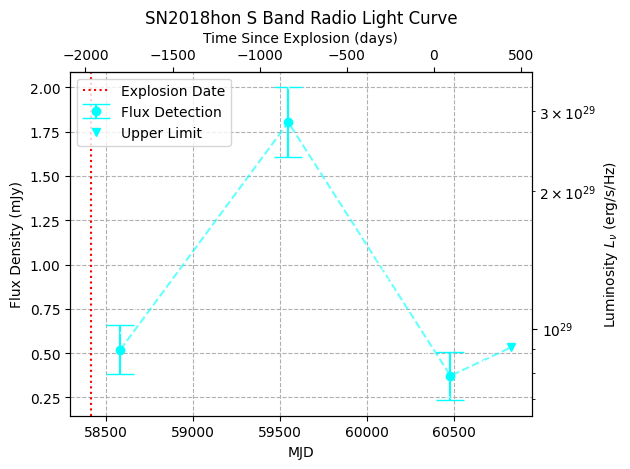

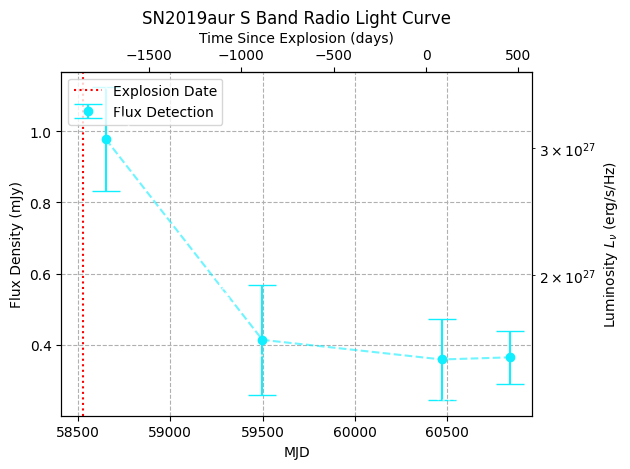

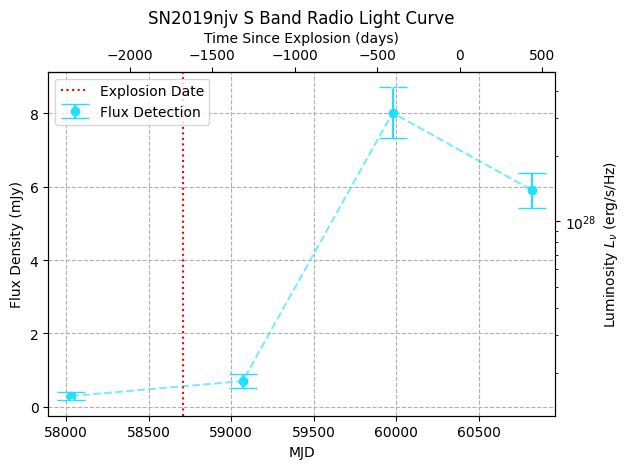

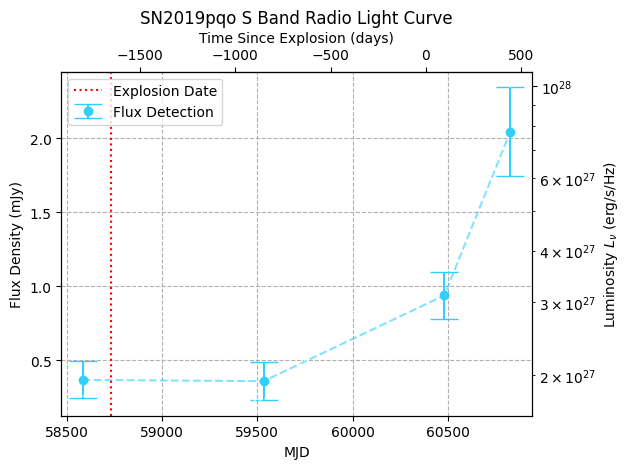

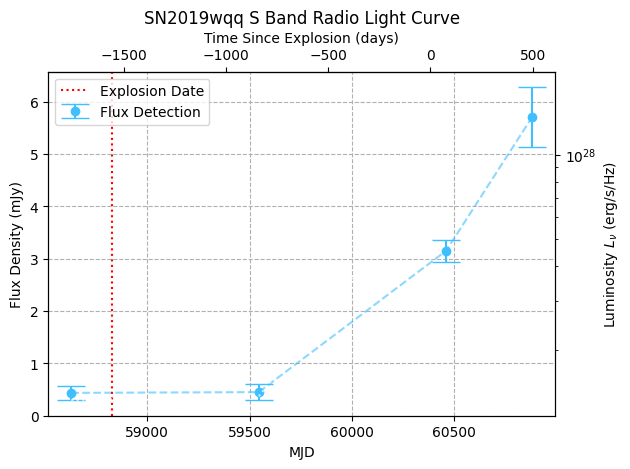

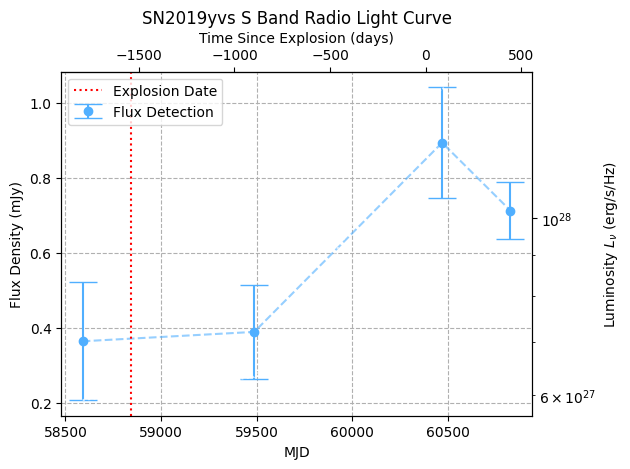

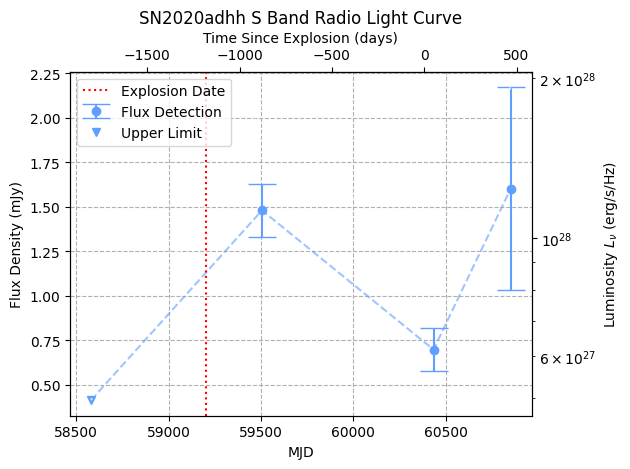

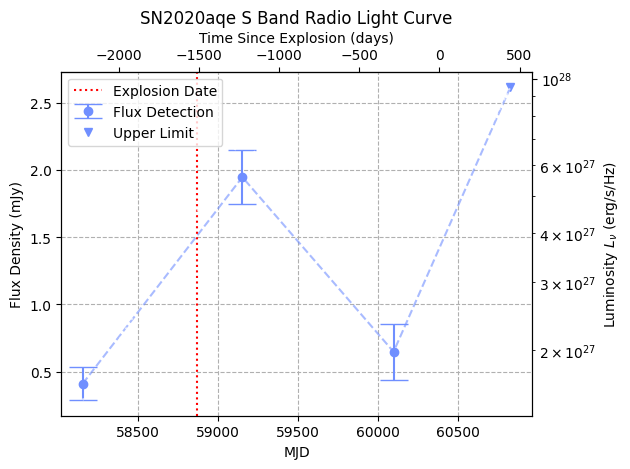

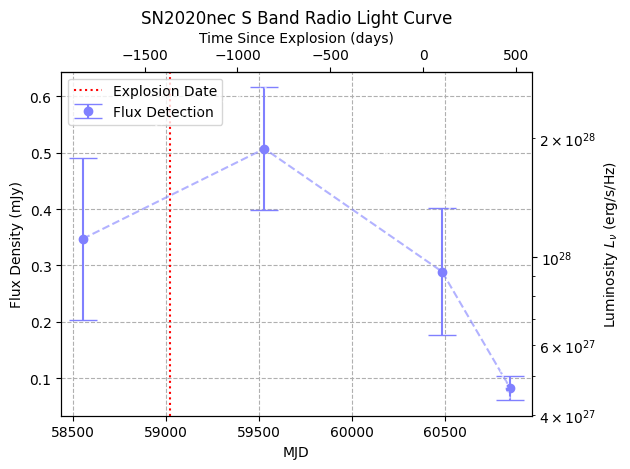

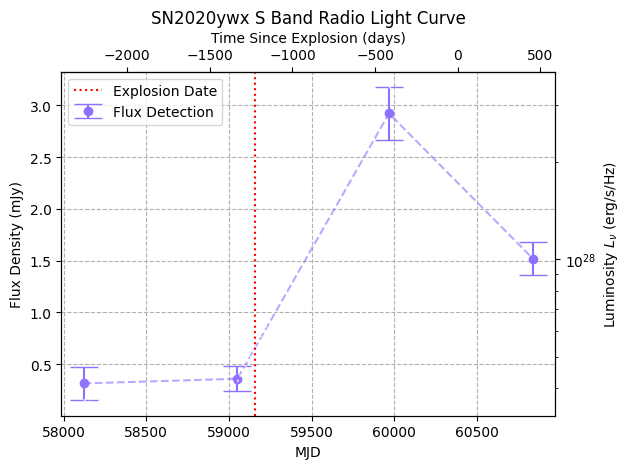

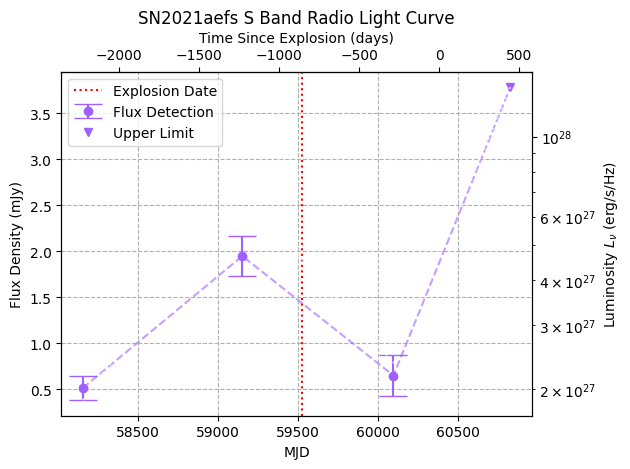

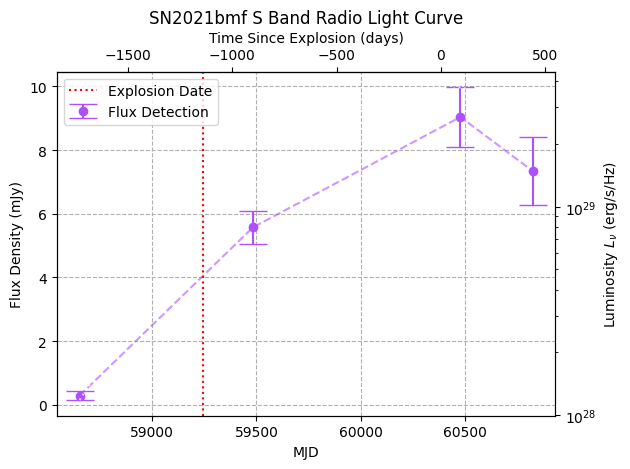

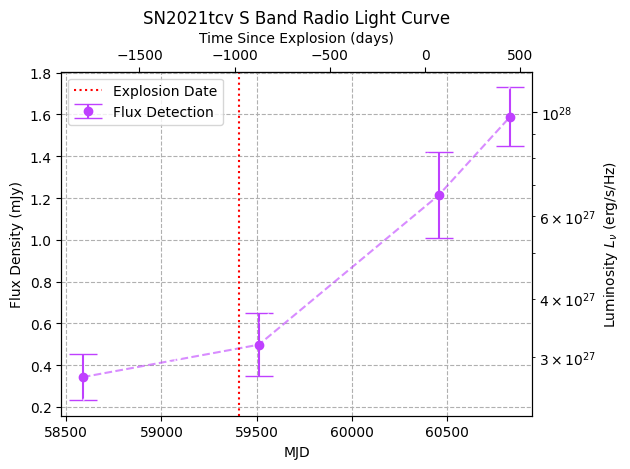

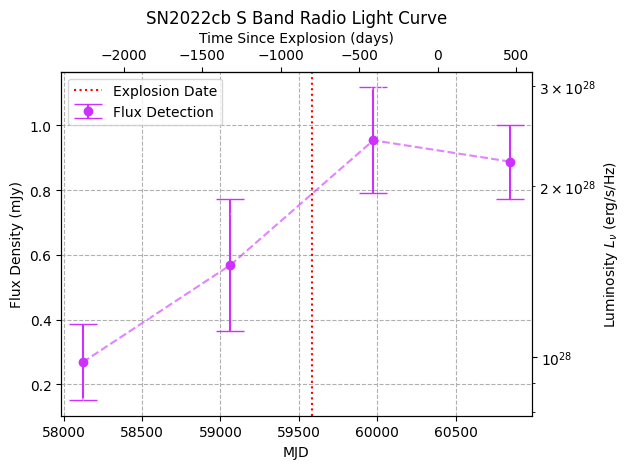

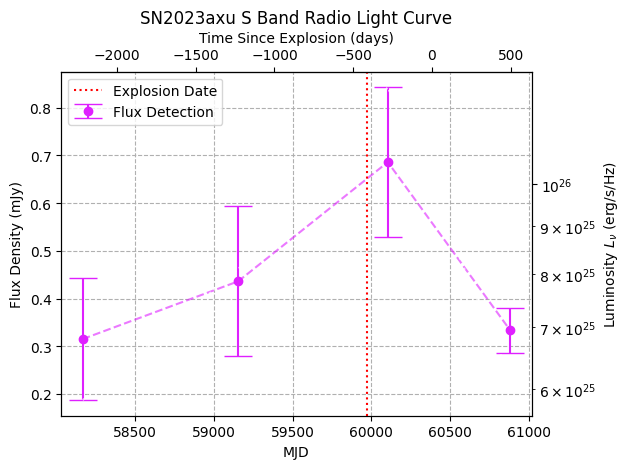

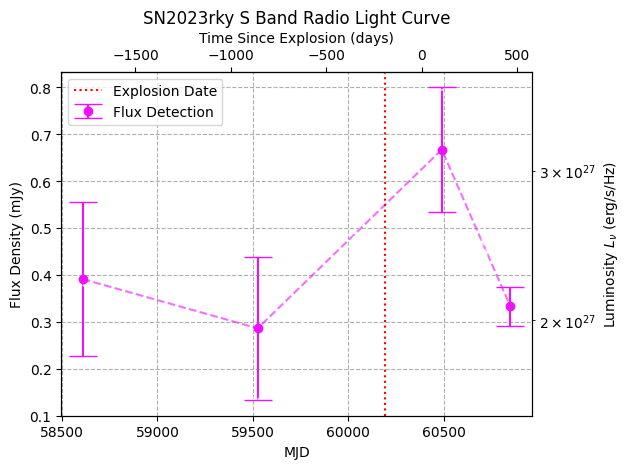

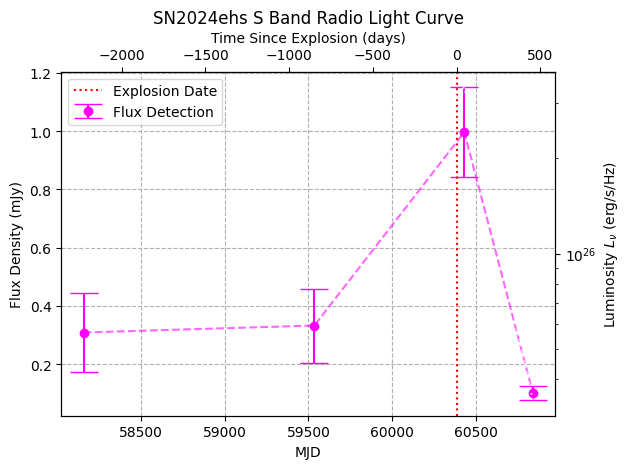

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

df = pd.read_csv("light_curve_data.csv")
df.columns = df.columns.str.strip()
df['Status'] = df['Status'].str.strip()

if 'PredictedFlux' not in df.columns:
    df['PredictedFlux'] = np.nan

supernovae = df['Name'].unique()
colormap = cm.get_cmap('cool', len(supernovae))

for i, name in enumerate(supernovae):
    subdf = df[df['Name'] == name]
    explosion_dates = subdf['ExplosionDate'].dropna().values
    explosion_date = explosion_dates[0] if len(explosion_dates) > 0 else None
    color = colormap(i)

    real_df = subdf[subdf['Status'] == 'real']
    upper_df = subdf[subdf['Status'] == 'upper']
    pred_df = subdf[subdf['PredictedFlux'].notna()]

    calcflux_df = subdf[subdf['CalculatedFlux'].notna()]
    if not calcflux_df.empty:
        for _, row in calcflux_df.iterrows():
            ax1.scatter(row['MJD'], row['CalculatedFlux'], marker='*', color='gold', s=100, label='Calculated Flux')


    fig, ax1 = plt.subplots()

    subdf_sorted = subdf.sort_values(by='MJD')
    ax1.plot(subdf_sorted['MJD'], subdf_sorted['Flux'], linestyle='--', color=color, alpha=0.6)

    if not real_df.empty:
        ax1.errorbar(real_df['MJD'], real_df['Flux'], yerr=real_df['RMS'],
                     fmt='o', color=color, ecolor=color, capsize=10, label='Flux Detection')

    if not upper_df.empty:
        ax1.errorbar(upper_df['MJD'], upper_df['Flux'],
                     fmt='v', color=color, ecolor=color, capsize=10, label='Upper Limit')

    if explosion_date is not None:
        ax1.axvline(x=explosion_date, color='red', linestyle=':', label='Explosion Date')
    
    ax1.set_xlabel("MJD")
    ax1.set_ylabel("Flux Density (mJy)")
    ax1.set_title(f"{name} S Band Radio Light Curve")
    ax1.grid(True, which="both", ls="--")
    ax1.legend(loc='upper left')

    def mjd_to_tse(x):
        return x - explosion_date if explosion_date is not None else x

    def tse_to_mjd(x):
        return x + explosion_date if explosion_date is not None else x

    ax2 = ax1.secondary_xaxis('top', functions=(mjd_to_tse, tse_to_mjd))
    ax2.set_xlabel("Time Since Explosion (days)")

    ax3 = ax1.twinx()
    ax3.set_ylabel("Luminosity $L_\\nu$ (erg/s/Hz)")
    ax3.set_yscale("log")

    ax3.plot(subdf_sorted['MJD'], subdf_sorted['luminosity (erg/s/Hz)'],
             linestyle=':', color='white', alpha=0.7, label='Luminosity')

    plt.tight_layout()
    plt.savefig(f'/Users/Djslime07/VLA_Summer25/light_curves_temp/{name}_Sband_lightcurve.png', format='png', bbox_inches='tight', dpi=1600)